# **Setup & Imports**

In [1]:
!nvidia-smi

Sun Nov 16 02:44:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install -U "transformers>=4.44"
!pip install -U "accelerate>=0.33"
!pip install -U "datasets>=2.20"
!pip install -U "evaluate>=0.4"
!pip install "huggingface-hub>=0.34.0,<1.0"
!pip install -U scikit-learn
!pip install -U sacrebleu
!pip install -U gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.5/511.5 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:0

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import glob
import os
import torch
from PIL import Image
import itertools
from datasets import Dataset
import evaluate
import os
import shutil
import json
from transformers import (
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer,
    set_seed,
    pipeline,
    EarlyStoppingCallback
)
from torch.nn import CrossEntropyLoss

# **Data Preparation**

In [5]:
!gdown 1fr-ZuEeJGi5kE1pA3EzlTvHfr-oN5U0P
!unzip Dataset_DFUs.zip
!rm Dataset_DFUs.zip

Downloading...
From: https://drive.google.com/uc?id=1fr-ZuEeJGi5kE1pA3EzlTvHfr-oN5U0P
To: /content/Dataset_DFUs.zip
100% 4.35M/4.35M [00:00<00:00, 22.3MB/s]
Archive:  Dataset_DFUs.zip
   creating: Dataset/
  inflating: __MACOSX/._Dataset      
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/0/
  inflating: __MACOSX/Dataset/._0    
   creating: Dataset/1/
  inflating: __MACOSX/Dataset/._1    
  inflating: Dataset/0/CG030_M_L.png  
  inflating: __MACOSX/Dataset/0/._CG030_M_L.png  
  inflating: Dataset/0/CG005_F_R.png  
  inflating: __MACOSX/Dataset/0/._CG005_F_R.png  
  inflating: Dataset/0/CG034_M_R.png  
  inflating: __MACOSX/Dataset/0/._CG034_M_R.png  
  inflating: Dataset/0/CG011_F_L.png  
  inflating: __MACOSX/Dataset/0/._CG011_F_L.png  
  inflating: Dataset/0/CG039_M_L.png  
  inflating: __MACOSX/Dataset/0/._CG039_M_L.png  
  inflating: Dataset/0/CG002_M_R.png  
  inflating: __MACOSX/Dataset/0/._CG002_M_R.png  
  inflating: Dat

In [11]:
count = glob.glob('Dataset/**/*.png', recursive=True)
print("Dataset amount:", len(count))

Dataset amount: 334


In [12]:
img_name = []
img_label = []

for file in glob.glob('Dataset/**/*.png', recursive=True):
    img_name.append(file)
    img_label.append(int(file.split("/")[-2]))

df_master = pd.DataFrame({
    'img_path': img_name,
    'label': img_label
})

print("Total images loaded:")
print(df_master['label'].value_counts())

X = df_master['img_path']
y = df_master['label']

Total images loaded:
label
1    244
0     90
Name: count, dtype: int64


In [13]:
df_master.head()

,img_path,label
0,Dataset/0/CG044_F_L.png,0
1,Dataset/0/CG013_M_R.png,0
2,Dataset/0/CG024_F_L.png,0
3,Dataset/0/CG042_F_R.png,0
4,Dataset/0/CG039_M_L.png,0


# **Configuration & Preprocessing**

In [14]:
model_checkpoint = 'google/vit-base-patch16-224'
feature_extractor = ViTImageProcessor.from_pretrained(model_checkpoint)

id2label = { 0: '0', 1: '1' }
label2id = { '0': 0, '1': 1 }

def transform(example_batch):
    inputs = feature_extractor([Image.open(x) for x in example_batch['img_path']], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

acc_metric  = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")
rec_metric  = evaluate.load("recall")
f1_metric   = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy":  acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": prec_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall":    rec_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1":        f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


# **Cross-Validation Training**

In [15]:
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)

class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32)

print(f"Using class weights: {class_weights_tensor}")

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = class_weights.to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None and labels is not None:
            loss_fct = CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.loss if outputs.loss is not None else super().compute_loss(model, inputs, return_outputs)

        return (loss, outputs) if return_outputs else loss

Using class weights: tensor([1.8556, 0.6844])


In [16]:
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

all_metrics = []
all_true_labels = np.array([], dtype=int)
all_predictions = np.array([], dtype=int)
fold_logs = []

--- Visualizing 5-Fold Split Distributions ---

--- FOLD 1/5 ---
Validation set distribution:
label
0    18
1    49
Name: count, dtype: int64

Displaying 5 sample validation images for Fold 1:


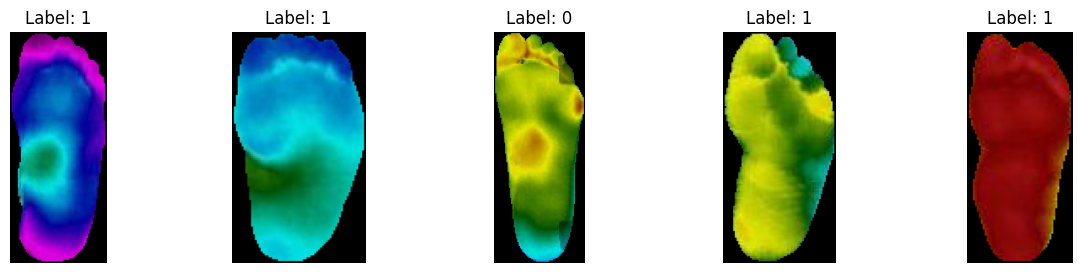


--- FOLD 2/5 ---
Validation set distribution:
label
0    18
1    49
Name: count, dtype: int64

Displaying 5 sample validation images for Fold 2:


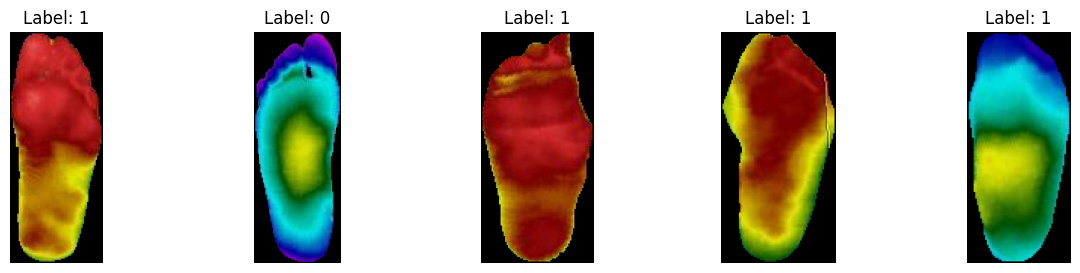


--- FOLD 3/5 ---
Validation set distribution:
label
0    18
1    49
Name: count, dtype: int64

Displaying 5 sample validation images for Fold 3:


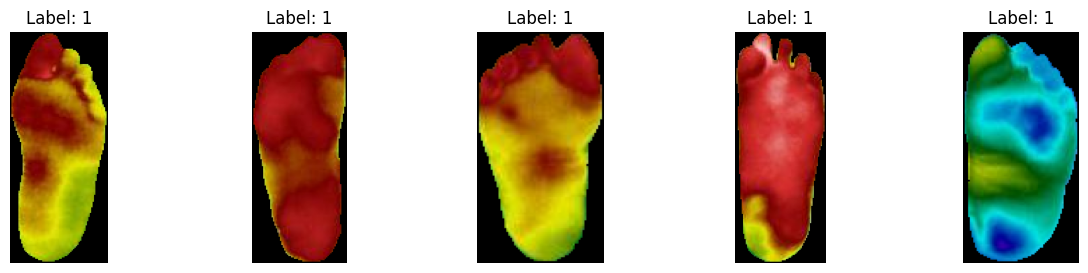


--- FOLD 4/5 ---
Validation set distribution:
label
0    18
1    49
Name: count, dtype: int64

Displaying 5 sample validation images for Fold 4:


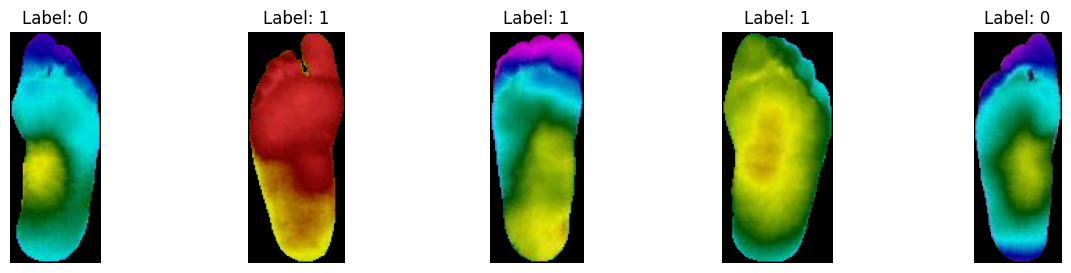


--- FOLD 5/5 ---
Validation set distribution:
label
0    18
1    48
Name: count, dtype: int64

Displaying 5 sample validation images for Fold 5:


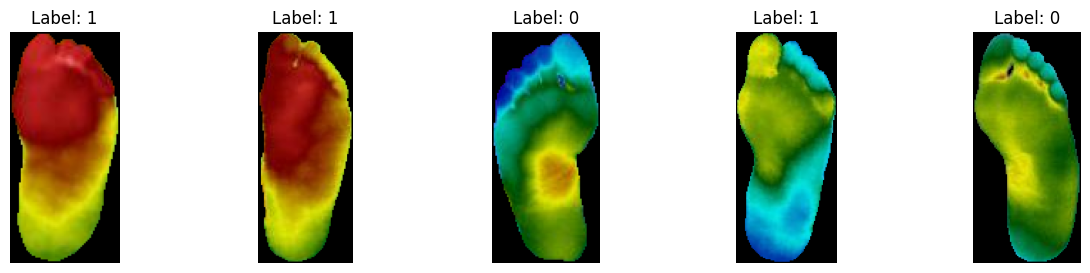

In [17]:
print("--- Visualizing 5-Fold Split Distributions ---")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")

    val_df = df_master.iloc[val_idx]
    val_labels = y.iloc[val_idx]

    val_counts = val_labels.value_counts().sort_index()
    print(f"Validation set distribution:\n{val_counts}\n")

    print(f"Displaying 5 sample validation images for Fold {fold + 1}:")

    sample_df = val_df.sample(min(5, len(val_df)))
    image_paths = sample_df['img_path'].tolist()
    image_labels = sample_df['label'].tolist()

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))

    for i, (path, label) in enumerate(zip(image_paths, image_labels)):
        try:
            img = Image.open(path)
            axs[i].imshow(img)
            axs[i].set_title(f"Label: {label}")
            axs[i].axis('off')
        except FileNotFoundError:
            axs[i].set_title("Image Not Found")
            axs[i].axis('off')

    plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class_weights_tensor = class_weights_tensor.to(device)

Using device: cuda


**Train the model**

In [19]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")

    set_seed(42 + fold)

    train_df = df_master.iloc[train_idx]
    val_df   = df_master.iloc[val_idx]

    train_dataset = Dataset.from_pandas(train_df).with_transform(transform)
    val_dataset   = Dataset.from_pandas(val_df).with_transform(transform)

    model = ViTForImageClassification.from_pretrained(
        model_checkpoint,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    model.to(device)

    training_args = TrainingArguments(
        output_dir=f"training_ViT_fold_{fold+1}",
        per_device_train_batch_size=64,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=15,
        logging_steps=10,
        learning_rate=3e-5,
        weight_decay=0.01,
        warmup_ratio=0.05,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        remove_unused_columns=False,
        metric_for_best_model="f1",
        load_best_model_at_end=True,
        use_mps_device= torch.backends.mps.is_available(),
        optim="adamw_torch",
        report_to="none",
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=feature_extractor,
        class_weights=class_weights_tensor,
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    best_dir = trainer.state.best_model_checkpoint or training_args.output_dir

    export_dir = f"export_vit_fold_{fold+1}"

    os.makedirs(export_dir, exist_ok=True)

    shutil.copytree(best_dir, export_dir, dirs_exist_ok=True)

    feature_extractor.save_pretrained(export_dir)

    torch.save({"id2label": id2label, "label2id": label2id}, os.path.join(export_dir, "label_map.pt"))

    print(f"[Fold {fold+1}] Saved best model to: {export_dir}")

    print(f"[Fold {fold+1}] Best metric (F1):", trainer.state.best_metric)
    print(f"[Fold {fold+1}] Best checkpoint:", trainer.state.best_model_checkpoint)
    print(f"[Fold {fold+1}] Epochs actually trained:", trainer.state.epoch)

    fold_logs.append(trainer.state.log_history)

    log_file_path = os.path.join(export_dir, f"fold_{fold+1}_log_history.json")
    with open(log_file_path, 'w') as f:
        json.dump(trainer.state.log_history, f, indent=4)
    print(f"[Fold {fold+1}] Saved log history to: {log_file_path}")

    print(f"--- Evaluating Fold {fold+1} ---")
    metrics = trainer.evaluate()
    print(metrics)

    predictions_output = trainer.predict(val_dataset)
    fold_preds = np.argmax(predictions_output.predictions, axis=1)

    all_predictions = np.concatenate((all_predictions, fold_preds))
    all_true_labels = np.concatenate((all_true_labels, predictions_output.label_ids))
    all_probs_pos   = np.array([], dtype=float)

    logits = predictions_output.predictions
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    probs_pos = probs[:, 1]

    # keep collecting
    all_probs_pos = np.concatenate((all_probs_pos, probs_pos))


    del model, trainer, predictions_output
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        torch.mps.empty_cache()

print("\n--- Cross-Validation Complete ---")


--- FOLD 1/5 ---


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2911309786.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.481184,0.761194,0.720450,0.766440,0.729293
2,0.507700,0.473780,0.761194,0.720450,0.766440,0.729293
3,0.507700,0.424921,0.791045,0.739899,0.769274,0.750532
4,0.166700,0.395293,0.835821,0.790022,0.799887,0.794650
5,0.166700,0.400856,0.835821,0.792941,0.782313,0.787302
6,0.042500,0.434264,0.835821,0.792941,0.782313,0.787302
7,0.042500,0.418396,0.880597,0.871968,0.812925,0.835784
8,0.010300,0.441547,0.835821,0.792941,0.782313,0.787302
9,0.010300,0.488541,0.835821,0.790022,0.799887,0.794650
10,0.004400,0.507901,0.835821,0.790022,0.799887,0.794650


[Fold 1] Saved best model to: export_vit_fold_1
[Fold 1] Best metric (F1): 0.8357843137254901
[Fold 1] Best checkpoint: training_ViT_fold_1/checkpoint-35
[Fold 1] Epochs actually trained: 15.0
[Fold 1] Saved log history to: export_vit_fold_1/fold_1_log_history.json
--- Evaluating Fold 1 ---


{'eval_loss': 0.41839584708213806, 'eval_accuracy': 0.8805970149253731, 'eval_precision': 0.871967654986523, 'eval_recall': 0.8129251700680271, 'eval_f1': 0.8357843137254901, 'eval_runtime': 0.2835, 'eval_samples_per_second': 236.297, 'eval_steps_per_second': 17.634, 'epoch': 15.0}

--- FOLD 2/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2911309786.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.552736,0.716418,0.727232,0.788549,0.703471
2,0.550200,0.342282,0.835821,0.796190,0.852608,0.811653
3,0.550200,0.301053,0.835821,0.802315,0.870181,0.815980
4,0.142200,0.223014,0.925373,0.900219,0.913832,0.906659
5,0.142200,0.234275,0.925373,0.893892,0.931406,0.909582
6,0.028200,0.212195,0.910448,0.886054,0.886054,0.886054
7,0.028200,0.219149,0.940299,0.914362,0.941610,0.926535
8,0.008300,0.257140,0.925373,0.893892,0.931406,0.909582
9,0.008300,0.286277,0.910448,0.875253,0.921202,0.893085
10,0.003600,0.281537,0.910448,0.875253,0.921202,0.893085


[Fold 2] Saved best model to: export_vit_fold_2
[Fold 2] Best metric (F1): 0.9265350877192983
[Fold 2] Best checkpoint: training_ViT_fold_2/checkpoint-35
[Fold 2] Epochs actually trained: 15.0
[Fold 2] Saved log history to: export_vit_fold_2/fold_2_log_history.json
--- Evaluating Fold 2 ---


{'eval_loss': 0.2191493809223175, 'eval_accuracy': 0.9402985074626866, 'eval_precision': 0.9143617021276595, 'eval_recall': 0.941609977324263, 'eval_f1': 0.9265350877192983, 'eval_runtime': 0.2719, 'eval_samples_per_second': 246.425, 'eval_steps_per_second': 18.39, 'epoch': 15.0}

--- FOLD 3/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2911309786.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.598389,0.671642,0.689964,0.740363,0.658796
2,0.607000,0.353266,0.776119,0.714118,0.706349,0.709957
3,0.607000,0.304570,0.835821,0.792941,0.782313,0.787302
4,0.274300,0.275342,0.835821,0.789855,0.817460,0.801080
5,0.274300,0.275552,0.910448,0.945455,0.833333,0.871154
6,0.088600,0.217427,0.925373,0.953704,0.861111,0.895083
7,0.088600,0.285477,0.910448,0.945455,0.833333,0.871154
8,0.020800,0.257230,0.910448,0.945455,0.833333,0.871154
9,0.020800,0.191748,0.925373,0.953704,0.861111,0.895083
10,0.006800,0.193879,0.925373,0.953704,0.861111,0.895083


[Fold 3] Saved best model to: export_vit_fold_3
[Fold 3] Best metric (F1): 0.8950829940494833
[Fold 3] Best checkpoint: training_ViT_fold_3/checkpoint-30
[Fold 3] Epochs actually trained: 15.0
[Fold 3] Saved log history to: export_vit_fold_3/fold_3_log_history.json
--- Evaluating Fold 3 ---


{'eval_loss': 0.21742719411849976, 'eval_accuracy': 0.9253731343283582, 'eval_precision': 0.9537037037037037, 'eval_recall': 0.8611111111111112, 'eval_f1': 0.8950829940494833, 'eval_runtime': 0.2737, 'eval_samples_per_second': 244.766, 'eval_steps_per_second': 18.266, 'epoch': 15.0}

--- FOLD 4/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2911309786.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.460982,0.805970,0.779946,0.849773,0.786989
2,0.499400,0.247515,0.940299,0.962264,0.888889,0.917892
3,0.499400,0.238565,0.910448,0.875000,0.938776,0.895963
4,0.168300,0.177592,0.940299,0.962264,0.888889,0.917892
5,0.168300,0.103818,0.955224,0.936952,0.951814,0.943996
6,0.061200,0.077568,0.970149,0.962018,0.962018,0.962018
7,0.061200,0.150752,0.940299,0.962264,0.888889,0.917892
8,0.016200,0.058593,0.970149,0.980392,0.944444,0.960588
9,0.016200,0.048600,1.000000,1.000000,1.000000,1.000000
10,0.006300,0.039774,1.000000,1.000000,1.000000,1.000000


[Fold 4] Saved best model to: export_vit_fold_4
[Fold 4] Best metric (F1): 1.0
[Fold 4] Best checkpoint: training_ViT_fold_4/checkpoint-45
[Fold 4] Epochs actually trained: 15.0
[Fold 4] Saved log history to: export_vit_fold_4/fold_4_log_history.json
--- Evaluating Fold 4 ---


{'eval_loss': 0.04859983175992966, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.2842, 'eval_samples_per_second': 235.72, 'eval_steps_per_second': 17.591, 'epoch': 15.0}

--- FOLD 5/5 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2911309786.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.346728,0.863636,0.823810,0.854167,0.836228
2,0.463700,0.341784,0.803030,0.779590,0.847222,0.785232
3,0.463700,0.210971,0.909091,0.897500,0.868056,0.881152
4,0.175500,0.267778,0.863636,0.833333,0.906250,0.848276
5,0.175500,0.123952,0.939394,0.914130,0.940972,0.926092
6,0.073700,0.107821,0.939394,0.909091,0.958333,0.928261
7,0.073700,0.142974,0.924242,0.891304,0.947917,0.911552
8,0.023400,0.083008,0.969697,0.950000,0.979167,0.963046
9,0.023400,0.096546,0.954545,0.928571,0.968750,0.945409
10,0.009200,0.090092,0.954545,0.928571,0.968750,0.945409


[Fold 5] Saved best model to: export_vit_fold_5
[Fold 5] Best metric (F1): 0.9630459126539753
[Fold 5] Best checkpoint: training_ViT_fold_5/checkpoint-40
[Fold 5] Epochs actually trained: 15.0
[Fold 5] Saved log history to: export_vit_fold_5/fold_5_log_history.json
--- Evaluating Fold 5 ---


{'eval_loss': 0.08300840109586716, 'eval_accuracy': 0.9696969696969697, 'eval_precision': 0.95, 'eval_recall': 0.9791666666666667, 'eval_f1': 0.9630459126539753, 'eval_runtime': 0.2748, 'eval_samples_per_second': 240.155, 'eval_steps_per_second': 18.194, 'epoch': 15.0}

--- Cross-Validation Complete ---


# **Results & Analysis for Cross Validation**

## **Helper function to plot the graph**

In [20]:
def curves_from_history(log_history):
    df = pd.DataFrame(log_history)

    if "loss" in df.columns:
        train_curve = (
            df[df["loss"].notna()]
            .groupby("epoch", as_index=False)["loss"]
            .last()
            .rename(columns={"loss": "train_loss"})
        )
    else:
        train_curve = pd.DataFrame(columns=["epoch", "train_loss"])

    if "eval_loss" in df.columns:
        agg_dict = {
            "eval_loss": ("eval_loss", "last")
        }
        if "eval_accuracy" in df.columns:
            agg_dict["eval_accuracy"] = ("eval_accuracy", "last")
        if "eval_f1" in df.columns:
            agg_dict["eval_f1"] = ("eval_f1", "last")

        eval_curve = (
            df[df["eval_loss"].notna()]
            .groupby("epoch", as_index=False)
            .agg(**agg_dict)
        )
    else:
        eval_curve = pd.DataFrame(columns=["epoch", "eval_loss", "eval_accuracy", "eval_f1"])

    curve = pd.merge(train_curve, eval_curve, on="epoch", how="outer").sort_values("epoch")
    return curve

def smooth_xy(x, y, points=200):
    m = ~np.isnan(x) & ~np.isnan(y)
    x, y = np.asarray(x)[m], np.asarray(y)[m]

    order = np.argsort(x)
    x, y = x[order], y[order]

    uniq_x, uniq_idx = np.unique(x, return_index=True)
    uniq_y = y[uniq_idx]

    if len(uniq_x) < 4:
        x_dense = np.linspace(uniq_x.min(), uniq_x.max(), points)
        y_dense = np.interp(x_dense, uniq_x, uniq_y)
        return x_dense, y_dense

    spline = make_interp_spline(uniq_x, uniq_y, k=3)

    x_dense = np.linspace(uniq_x.min(), uniq_x.max(), points)
    y_dense = spline(x_dense)

    return x_dense, y_dense

fold_curves = [curves_from_history(h) for h in fold_logs]

## Plot the graph

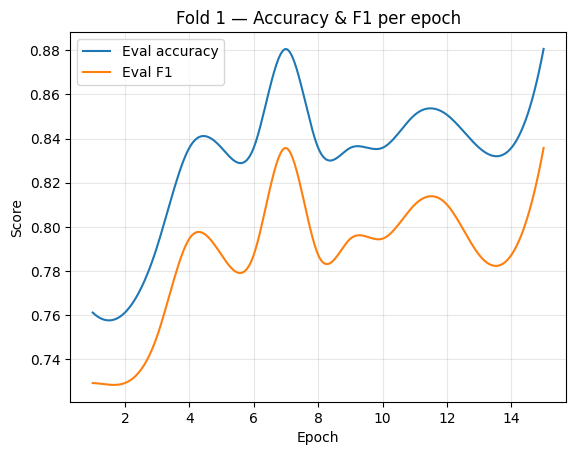

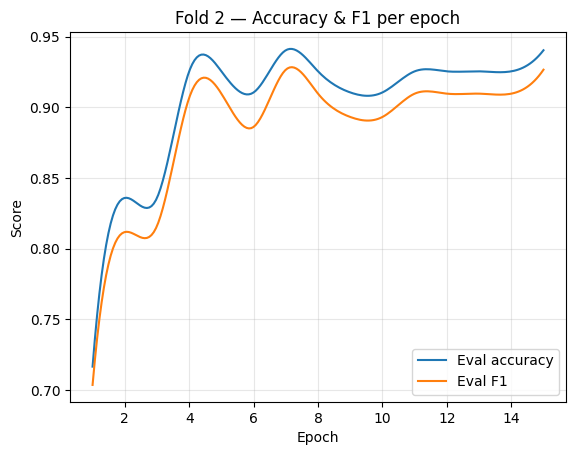

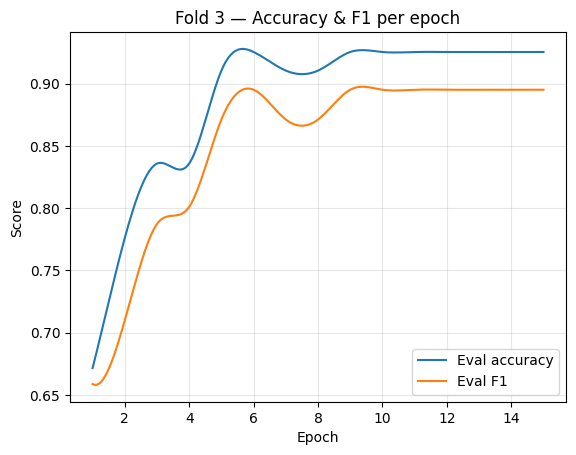

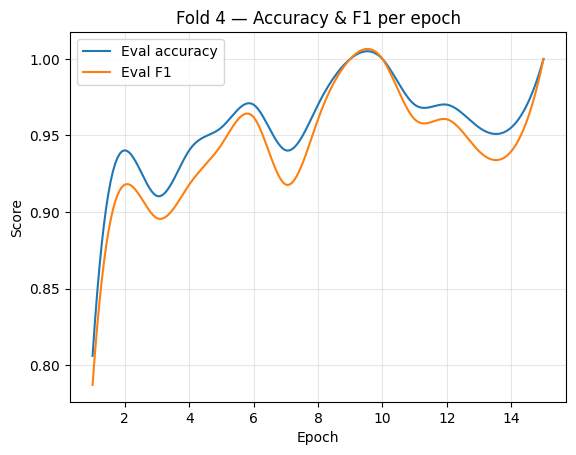

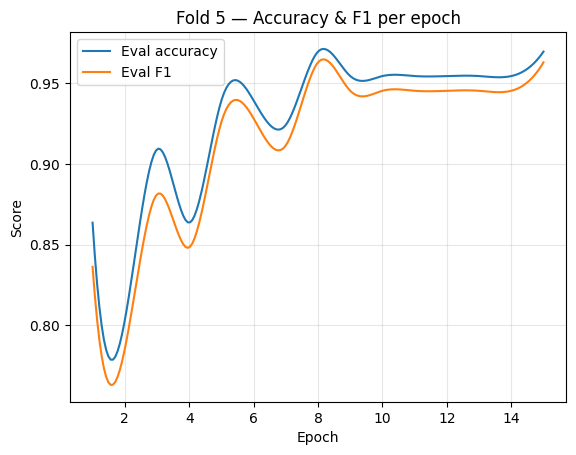

In [21]:
for i, curve in enumerate(fold_curves, 1):
    plt.figure()

    x_acc, y_acc = smooth_xy(curve["epoch"].values, curve["eval_accuracy"].values)
    plt.plot(x_acc, y_acc, label="Eval accuracy", marker='')

    x_f1, y_f1 = smooth_xy(curve["epoch"].values, curve["eval_f1"].values)
    plt.plot(x_f1, y_f1, label="Eval F1", marker='')

    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"Fold {i} — Accuracy & F1 per epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

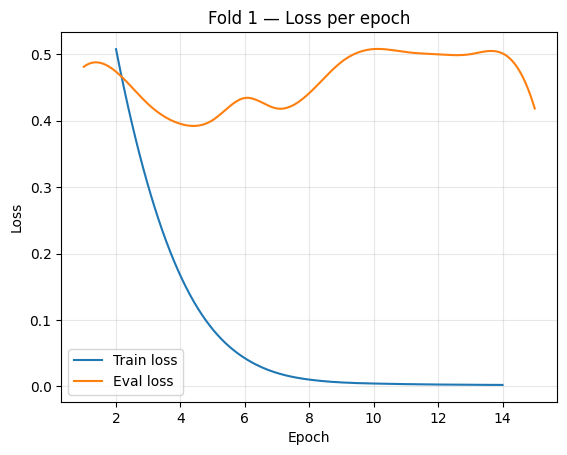

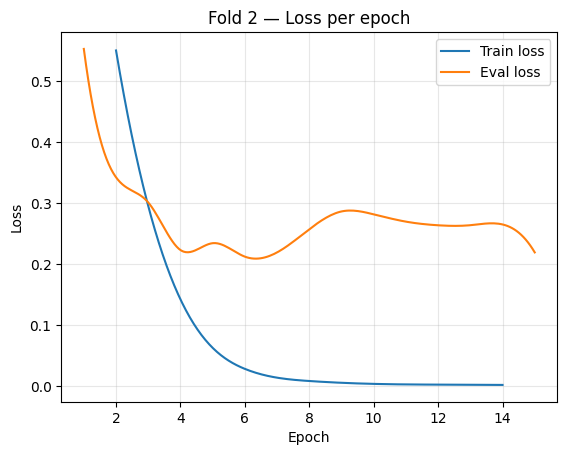

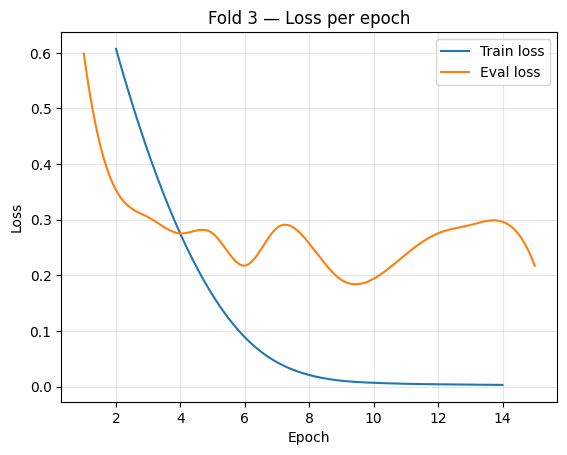

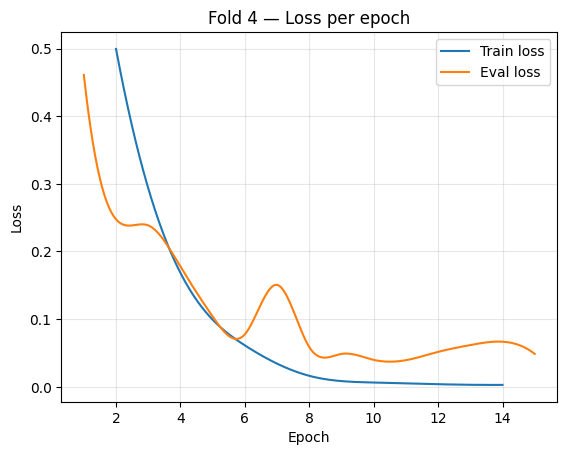

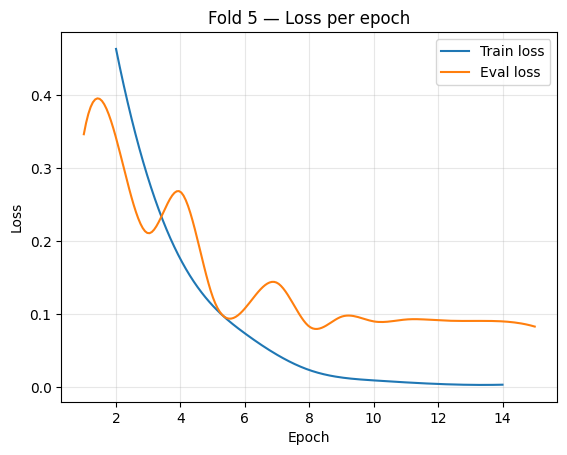

In [22]:
for i, curve in enumerate(fold_curves, 1):
    plt.figure()

    x_tr, y_tr = smooth_xy(curve["epoch"].values, curve["train_loss"].values)
    plt.plot(x_tr, y_tr, label="Train loss", marker='')

    x_ev, y_ev = smooth_xy(curve["epoch"].values, curve["eval_loss"].values)
    plt.plot(x_ev, y_ev, label="Eval loss", marker='')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {i} — Loss per epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

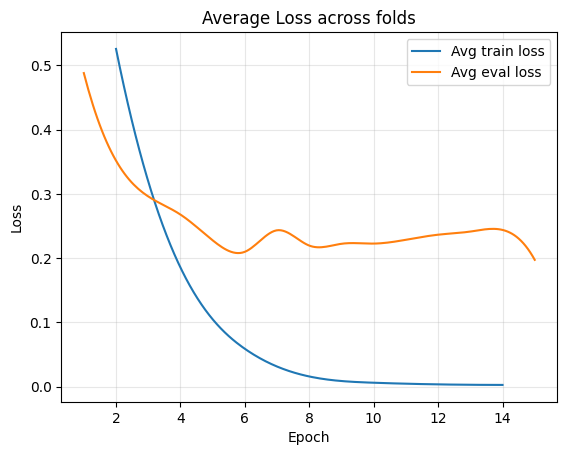

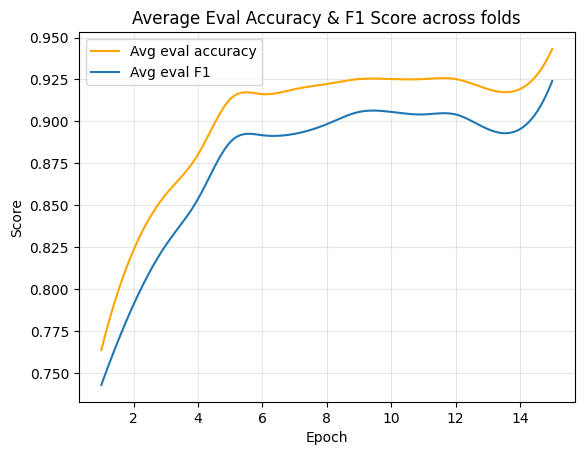

In [23]:
all_eval = []
all_train = []
for c in fold_curves:
    all_eval.append(c[["epoch", "eval_loss", "eval_accuracy", "eval_f1"]].dropna())
    all_train.append(c[["epoch", "train_loss"]].dropna())

avg_eval = (pd.concat(all_eval)
            .groupby("epoch", as_index=False)
            .mean(numeric_only=True))
avg_train = (pd.concat(all_train)
             .groupby("epoch", as_index=False)
             .mean(numeric_only=True))

plt.figure()
x_train_loss, y_train_loss = smooth_xy(avg_train["epoch"], avg_train["train_loss"])
plt.plot(x_train_loss, y_train_loss, label="Avg train loss", marker='')
x_eval_loss, y_eval_loss = smooth_xy(avg_eval["epoch"],  avg_eval["eval_loss"])
plt.plot(x_eval_loss, y_eval_loss, label="Avg eval loss", marker='')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Average Loss across folds")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure()
x_eval_acc, y_eval_acc = smooth_xy(avg_eval["epoch"], avg_eval["eval_accuracy"])
plt.plot(x_eval_acc, y_eval_acc, label="Avg eval accuracy", marker='', color='orange')

x_eval_f1, y_eval_f1 = smooth_xy(avg_eval["epoch"], avg_eval["eval_f1"])
plt.plot(x_eval_f1, y_eval_f1, label="Avg eval F1", marker='')

plt.xlabel("Epoch"); plt.ylabel("Score")
plt.title("Average Eval Accuracy & F1 Score across folds")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

**Confusion Matrix**

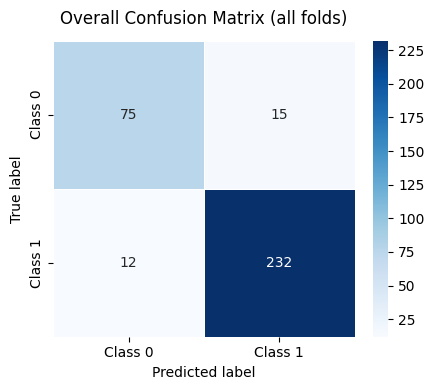

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true_labels, all_predictions)
labels = ["Class 0", "Class 1"] 

plt.figure(figsize=(4.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Overall Confusion Matrix (all folds)", pad=12)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


## Report

--- Fold 1: loading training_ViT_fold_1/checkpoint-75 ---


--- Fold 2: loading training_ViT_fold_2/checkpoint-75 ---


--- Fold 3: loading training_ViT_fold_3/checkpoint-75 ---


--- Fold 4: loading training_ViT_fold_4/checkpoint-75 ---


--- Fold 5: loading training_ViT_fold_5/checkpoint-75 ---


,fold,accuracy,precision,recall,f1
0,1,0.835821,0.880000,0.897959,0.888889
1,2,0.925373,0.978261,0.918367,0.947368
2,3,0.925373,0.907407,1.000000,0.951456
3,4,0.955224,0.942308,1.000000,0.970297
4,5,0.954545,1.000000,0.937500,0.967742



===== Mean ± Std across folds =====
accuracy  : 0.9193 ± 0.0489
precision : 0.9416 ± 0.0493
recall    : 0.9508 ± 0.0471
f1        : 0.9452 ± 0.0330

Saved to cv_metrics_summary.csv

Micro accuracy (all folds combined): 0.9192

              precision    recall  f1-score   support

           0     0.8621    0.8333    0.8475        90
           1     0.9393    0.9508    0.9450       244

    accuracy                         0.9192       334
   macro avg     0.9007    0.8921    0.8962       334
weighted avg     0.9185    0.9192    0.9187       334



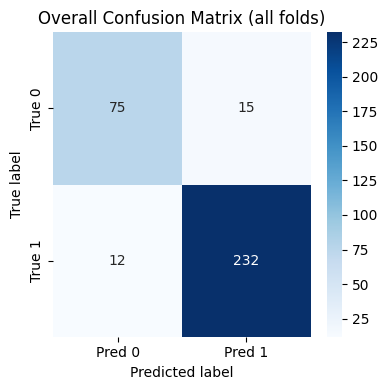

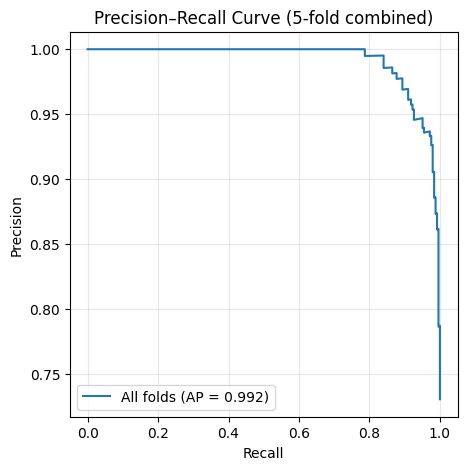

Combined Average Precision: 0.9916


In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    classification_report,
)

from datasets import Dataset
from transformers import ViTForImageClassification, Trainer, TrainingArguments

all_metrics      = []   
all_true_labels  = []   
all_predictions  = [] 
all_probs_pos    = []  

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    fold_dir = f"training_ViT_fold_{fold}"
    ckpts = [os.path.join(fold_dir, c) for c in os.listdir(fold_dir) if c.startswith("checkpoint")]
    if not ckpts:
        print(f" No checkpoint found for fold {fold}, skipping.")
        continue

    ckpts.sort(key=lambda p: int(p.split("-")[-1]))
    latest_ckpt = ckpts[-1]
    print(f"--- Fold {fold}: loading {latest_ckpt} ---")

    val_df = df_master.iloc[val_idx].reset_index(drop=True)
    val_dataset = Dataset.from_pandas(val_df).with_transform(transform)

    model = ViTForImageClassification.from_pretrained(latest_ckpt)

    eval_args = TrainingArguments(
        output_dir="tmp_eval",
        per_device_eval_batch_size=16,
        remove_unused_columns=False,
        report_to="none",
    )
    eval_trainer = Trainer(
        model=model,
        args=eval_args,
        data_collator=collate_fn,
    )

    preds_output = eval_trainer.predict(val_dataset)
    logits = preds_output.predictions         
    y_true = preds_output.label_ids            
    y_pred = np.argmax(logits, axis=1)

    logits_shifted = logits - np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits_shifted)
    probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    probs_pos = probs[:, 1]

    all_true_labels.append(y_true)
    all_predictions.append(y_pred)
    all_probs_pos.append(probs_pos)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec  = recall_score(y_true, y_pred, pos_label=1)
    f1   = f1_score(y_true, y_pred, pos_label=1)

    all_metrics.append({
        "fold": fold,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    })

all_true_labels = np.concatenate(all_true_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)
all_probs_pos   = np.concatenate(all_probs_pos, axis=0)

metrics_df = pd.DataFrame(all_metrics)
display(metrics_df)

print("\n===== Mean ± Std across folds =====")
for col in ["accuracy", "precision", "recall", "f1"]:
    print(f"{col:10s}: {metrics_df[col].mean():.4f} ± {metrics_df[col].std():.4f}")

metrics_df.to_csv("cv_metrics_summary.csv", index=False)
print("\nSaved to cv_metrics_summary.csv")

cm = confusion_matrix(all_true_labels, all_predictions)
acc_micro = (cm.trace()) / cm.sum()
print(f"\nMicro accuracy (all folds combined): {acc_micro:.4f}\n")
print(classification_report(all_true_labels, all_predictions, digits=4))

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"],
)
plt.title("Overall Confusion Matrix (all folds)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(all_true_labels, all_probs_pos)
ap = average_precision_score(all_true_labels, all_probs_pos)

plt.figure(figsize=(5, 5))
plt.plot(recall, precision, label=f"All folds (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (5-fold combined)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Combined Average Precision: {ap:.4f}")


# **Train Final Model**

In [43]:
print("--- Training Final Model on All Data ---")

set_seed(42)

final_train_df = df_master
final_train_dataset = Dataset.from_pandas(final_train_df).with_transform(transform)

final_model = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

final_training_args = TrainingArguments(
    output_dir="final_vit_model_training",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    eval_strategy="no",
    save_strategy="epoch",
    num_train_epochs=15,
    logging_steps=10,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.05,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    use_mps_device=torch.backends.mps.is_available(),
    optim="adamw_torch",
    report_to="none",
)

final_trainer = CustomTrainer(
    model=final_model,
    args=final_training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=final_train_dataset,
    tokenizer=feature_extractor,
    class_weights=class_weights_tensor,
)

final_trainer.train()

final_export_dir = "final_vit_model"
os.makedirs(final_export_dir, exist_ok=True)

final_trainer.save_model(final_export_dir)
feature_extractor.save_pretrained(final_export_dir)
torch.save({"id2label": id2label, "label2id": label2id},
           os.path.join(final_export_dir, "label_map.pt"))

print(f"--- Final Model Saved to: {final_export_dir} ---")

shutil.rmtree("final_vit_model_training")


--- Training Final Model on All Data ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2911309786.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
10,0.530100
20,0.224100
30,0.065600
40,0.017200
50,0.005600
60,0.003100
70,0.002100
80,0.001800
90,0.001800


--- Final Model Saved to: final_vit_model ---


# **Try final the model**

In [44]:
model = ViTForImageClassification.from_pretrained("final_vit_model")
processor = ViTImageProcessor.from_pretrained("final_vit_model")


In [45]:
clf = pipeline(
    "image-classification",
    model= "final_vit_model",
    device=0 if torch.cuda.is_available() else -1
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [47]:
img_path = "/content/Dataset/1/DM004_M_R.png"

print(clf(img_path, top_k=2))

[{'label': '1', 'score': 0.9998236298561096}, {'label': '0', 'score': 0.00017636583652347326}]


# **Save all content to Google Drive**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, pathlib

SAVE_DIR = "/content/drive/MyDrive/colab_backups"
SRC_ROOT = "/content"

folder_prefixes = ("export_vit_fold_", "training_ViT_fold_")
extra_folders   = {"Dataset", "sample_data", "final_vit_model"}   

pathlib.Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

for name in os.listdir(SRC_ROOT):
    src_path = os.path.join(SRC_ROOT, name)
    if os.path.isdir(src_path):
        if name.startswith(folder_prefixes) or name in extra_folders:
            dst_path = os.path.join(SAVE_DIR, name)
            print(f"Copying folder {src_path} -> {dst_path}")
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

csv_src = os.path.join(SRC_ROOT, "cv_metrics_summary.csv")
if os.path.exists(csv_src):
    csv_dst = os.path.join(SAVE_DIR, "cv_metrics_summary.csv")
    print(f"Copying file {csv_src} -> {csv_dst}")
    shutil.copy2(csv_src, csv_dst)
else:
    print("cv_metrics_summary.csv not found in /content")

print("Done!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying folder /content/training_ViT_fold_2 -> /content/drive/MyDrive/colab_backups/training_ViT_fold_2
Copying folder /content/training_ViT_fold_3 -> /content/drive/MyDrive/colab_backups/training_ViT_fold_3
Copying folder /content/training_ViT_fold_1 -> /content/drive/MyDrive/colab_backups/training_ViT_fold_1
Copying folder /content/final_vit_model -> /content/drive/MyDrive/colab_backups/final_vit_model
Copying folder /content/Dataset -> /content/drive/MyDrive/colab_backups/Dataset
Copying folder /content/export_vit_fold_3 -> /content/drive/MyDrive/colab_backups/export_vit_fold_3
Copying folder /content/export_vit_fold_1 -> /content/drive/MyDrive/colab_backups/export_vit_fold_1
Copying folder /content/training_ViT_fold_4 -> /content/drive/MyDrive/colab_backups/training_ViT_fold_4
Copying folder /content/training_ViT_fold_5 -> /content/drive/MyDrive/colab_bac

# **Grad-Cam**

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from transformers import ViTImageProcessor, ViTForImageClassification
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [85]:
MODEL_FOLDER_PATH = "final_vit_model"
IMAGE_PATH_1 = "img/[1] DFU/DM115_F_R.png"  
IMAGE_PATH_2 = "img/[1] DFU/DM115_F_L.png" 
TARGET_CLASS_INDEX = 1


In [86]:
def reshape_transform(tensor):
    tensor = tensor[:, 1:, :]         

    B, N, C = tensor.shape
    H = W = int(N ** 0.5)             

    tensor = tensor.reshape(B, H, W, C)   
    tensor = tensor.permute(0, 3, 1, 2) 
    return tensor

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits


In [ ]:
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

Using device: mps


In [88]:
processor = ViTImageProcessor.from_pretrained(MODEL_FOLDER_PATH)
hf_model = ViTForImageClassification.from_pretrained(MODEL_FOLDER_PATH)

model = HuggingfaceToTensorModelWrapper(hf_model).to(device).eval()

target_layers = [model.model.vit.encoder.layer[-1].layernorm_before]

cam = GradCAM(
    model=model,
    target_layers=target_layers,
    reshape_transform=reshape_transform
)

targets = [ClassifierOutputTarget(TARGET_CLASS_INDEX)]

image_paths = [IMAGE_PATH_1, IMAGE_PATH_2]
rgb_images = []          
cam_visualizations = []  

In [89]:
for p in image_paths:
    pil_img = Image.open(p).convert("RGB")

    img_np = np.array(pil_img).astype(np.float32) / 255.0 
    rgb_images.append(img_np)

    inputs = processor(images=pil_img, return_tensors="pt")
    input_tensor = inputs["pixel_values"].to(device)  

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :] 

    H, W, _ = img_np.shape
    grayscale_cam_resized = cv2.resize(grayscale_cam, (W, H))

    cam_vis = show_cam_on_image(img_np, grayscale_cam_resized, use_rgb=True)
    cam_visualizations.append(cam_vis)

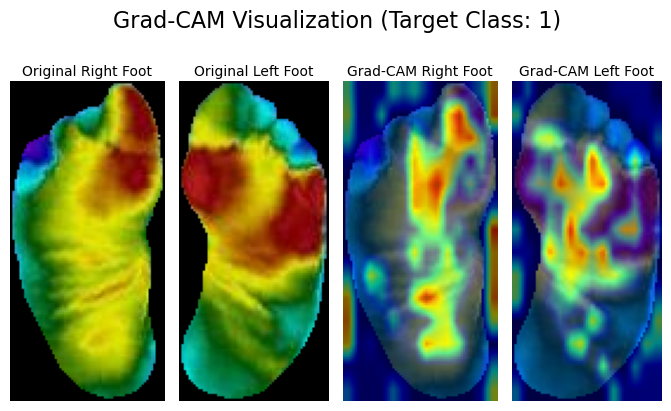

In [90]:
fig, axes = plt.subplots(1, 4, figsize=(7, 4))

fig.suptitle(
    f"Grad-CAM Visualization (Target Class: {TARGET_CLASS_INDEX})",
    fontsize=16,
    y=1.03
)

axes[0].imshow(rgb_images[0])
axes[0].set_title("Original Right Foot", fontsize=10, pad=4)
axes[0].axis('off')

axes[1].imshow(rgb_images[1])
axes[1].set_title("Original Left Foot", fontsize=10, pad=4)
axes[1].axis('off')

axes[2].imshow(cam_visualizations[0])
axes[2].set_title("Grad-CAM Right Foot", fontsize=10, pad=4)
axes[2].axis('off')

axes[3].imshow(cam_visualizations[1])
axes[3].set_title("Grad-CAM Left Foot", fontsize=10, pad=4)
axes[3].axis('off')

fig.subplots_adjust(
    wspace=0.05,
    left=0.03,
    right=0.97,
    top=0.85,
    bottom=0.05
)

plt.show()
